Code adapted from https://abhinavcreed13.github.io/blog/bengio-trigram-nplm-using-pytorch/

In [1]:
#load wikitext data

train = []
test = []

train_file_path = '../newtraincorpus.txt'
test_file_path = '../newtestcorpus.txt'

with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            train.append(words)

with open(test_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            test.append(words)

print(len(train))
print(len(test))

77363
9418


In [2]:
train[0]

['valkyria',
 'of',
 'the',
 'battlefield',
 '<num>',
 'commonly',
 'referred',
 'to',
 'as',
 'valkyria',
 'chronicles',
 'iii',
 'outside',
 'japan',
 'is',
 'a',
 'tactical',
 'role',
 '@-@',
 'playing',
 'video',
 'game',
 'developed',
 'by',
 'sega',
 'and',
 'media']

In [3]:
#create vocabulary


UNK_symbol = "<UNK>"
vocab = set([UNK_symbol])



# create term frequency of the words
words_term_frequency_train = {}
for doc in train:
    for word in doc:
        # this will calculate term frequency
        # since we are taking all words now
        words_term_frequency_train[word] = words_term_frequency_train.get(word,0) + 1

# create vocabulary
for doc in train:
    for word in doc:
        if words_term_frequency_train.get(word,0) >= 5:
            vocab.add(word)

# remove "@-@" from vocab
vocab.remove("@-@")

print(len(vocab))

19114


In [4]:
#create 5-grams

import numpy as np
# create required lists
x_train = []
y_train = []

x_test = []
y_test = []


# create word to id mappings
word_to_id_mappings = {}
for idx,word in enumerate(vocab):
    word_to_id_mappings[word] = idx

# function to get id for a given word
# return <UNK> id if not found
def get_id_of_word(word):
    unknown_word_id = word_to_id_mappings['<UNK>']
    return word_to_id_mappings.get(word,unknown_word_id)

# creating training and dev set
for sentence in train:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_train.append(x_extract)
        y_train.append(y_extract)

for sentence in test:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_test.append(x_extract)
        y_test.append(y_extract)
  

# making numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)  
  
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1333059, 4)
(1333059, 1)
(156022, 4)
(156022, 1)


In [33]:
#save word to id mapping
import pickle
with open("word2idmaps/5gram.pkl", 'wb') as f:
    pickle.dump(word_to_id_mappings, f)


In [8]:
# load libraries
import torch
import multiprocessing
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [9]:
# Trigram Neural Network Model
class fiveGramNNmodel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(fiveGramNNmodel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size, bias = False)

    def forward(self, inputs):
        # compute x': concatenation of x1 and x2 embeddings
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = F.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

In [30]:
# create parameters
gpu = 0 
# word vectors size
EMBEDDING_DIM = 200
CONTEXT_SIZE = 4
BATCH_SIZE = 128
# hidden units
H = 200
torch.manual_seed(13013)

# check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
available_workers = multiprocessing.cpu_count()

print("--- Creating training and dev dataloaders with {} batch size ---".format(BATCH_SIZE))
train_set = np.concatenate((x_train, y_train), axis=1)
test_set = np.concatenate((x_test, y_test), axis=1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, num_workers = available_workers)

cuda
--- Creating training and dev dataloaders with 128 batch size ---


In [31]:
# helper function to get accuracy from log probabilities
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc

# helper function to evaluate model on dev data
def evaluate(model, criterion, dataloader, gpu):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    losses = []
    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
            target_tensor = data_tensor[:,4].type(torch.LongTensor)
            context_tensor, target_tensor = context_tensor.cuda(gpu), target_tensor.cuda(gpu)
            log_probs = model(context_tensor)
            loss = criterion(log_probs, target_tensor)
            mean_loss += loss.item()
            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1
            if it % 50 == 0:
                losses.append(loss.item())
            if it % 500 == 0: 
                print("Dev Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(it, mean_loss / count, mean_acc / count, (time.time()-dev_st)))
                dev_st = time.time()

    return mean_acc / count, mean_loss / count, losses

import matplotlib.pyplot as plt

def plot_loss(losses, title):
    batches = range(1, len(losses) + 1)
    plt.plot(batches, losses, 'b', label='Training loss')
    plt.title(title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
for it, data_tensor in enumerate(train_loader):       
    print(data_tensor[:,0:4])
    print(data_tensor[:,4])
    break

tensor([[14067, 14224,  2925,  7746],
        [14224,  2925,  7746,  7267],
        [ 2925,  7746,  7267, 17816],
        [ 7746,  7267, 17816, 15158],
        [ 7267, 17816, 15158, 12767],
        [17816, 15158, 12767,  5724],
        [15158, 12767,  5724, 14067],
        [12767,  5724, 14067,  4686],
        [ 5724, 14067,  4686,  2745],
        [14067,  4686,  2745,  4982],
        [ 4686,  2745,  4982,   667],
        [ 2745,  4982,   667,  4400],
        [ 4982,   667,  4400,  5320],
        [  667,  4400,  5320, 16583],
        [ 4400,  5320, 16583, 13678],
        [ 5320, 16583, 13678,  7156],
        [16583, 13678,  7156,  1220],
        [13678,  7156,  1220, 16767],
        [ 7156,  1220, 16767,  2451],
        [ 1220, 16767,  2451,  8643],
        [16767,  2451,  8643, 18121],
        [ 2451,  8643, 18121, 10209],
        [ 8643, 18121, 10209,  6710],
        [ 4098,  5789,  2925, 10108],
        [  589,  5604, 11793,  4367],
        [ 5604, 11793,  4367,  5604],
        [117


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 9.873109817504883; Acc:0.0; Time taken (s): 21.708293676376343
Training Iteration 500 of epoch 0 complete. Loss: 7.213131904602051; Acc:0.09375; Time taken (s): 2.5759971141815186
Training Iteration 1000 of epoch 0 complete. Loss: 6.517401218414307; Acc:0.1875; Time taken (s): 2.4498186111450195
Training Iteration 1500 of epoch 0 complete. Loss: 6.388817310333252; Acc:0.1171875; Time taken (s): 2.4890623092651367
Training Iteration 2000 of epoch 0 complete. Loss: 7.9890265464782715; Acc:0.0703125; Time taken (s): 2.410001039505005
Training Iteration 2500 of epoch 0 complete. Loss: 6.859597206115723; Acc:0.1015625; Time taken (s): 2.417001485824585
Training Iteration 3000 of epoch 0 complete. Loss: 7.201683044433594; Acc:0.09375; Time taken (s): 2.4240024089813232
Training Iteration 3500 of epoch 0 complete. Loss: 6.693386077880859; Acc:0.1484375; Time taken (s): 2.419001340866089
Training Iteration 4000 of

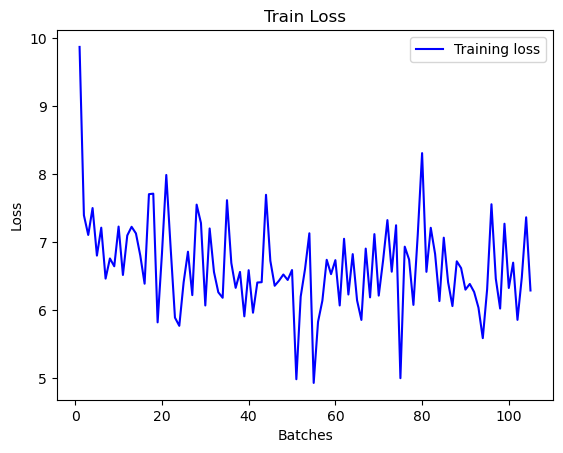

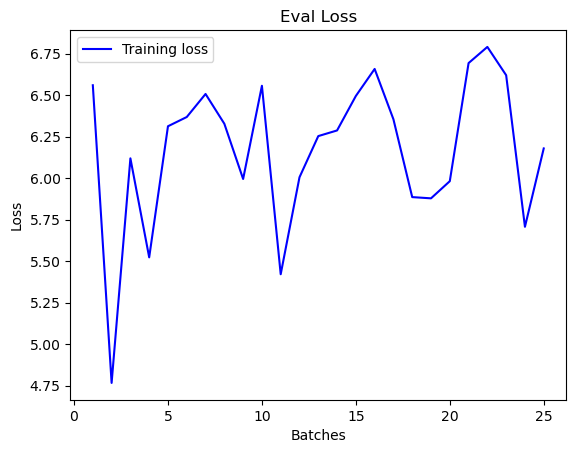

Best development accuracy improved from 0 to 0.1658390760421753, saving model...

--- Training model Epoch: 2 ---
Training Iteration 0 of epoch 1 complete. Loss: 6.7127485275268555; Acc:0.125; Time taken (s): 22.11674737930298
Training Iteration 500 of epoch 1 complete. Loss: 6.704353332519531; Acc:0.15625; Time taken (s): 2.555002212524414
Training Iteration 1000 of epoch 1 complete. Loss: 6.212861061096191; Acc:0.171875; Time taken (s): 2.4589574337005615
Training Iteration 1500 of epoch 1 complete. Loss: 5.729724884033203; Acc:0.1875; Time taken (s): 2.4110019207000732
Training Iteration 2000 of epoch 1 complete. Loss: 7.221251487731934; Acc:0.140625; Time taken (s): 2.418001413345337
Training Iteration 2500 of epoch 1 complete. Loss: 5.582622051239014; Acc:0.21875; Time taken (s): 2.405001640319824
Training Iteration 3000 of epoch 1 complete. Loss: 6.5002923011779785; Acc:0.1171875; Time taken (s): 2.408116102218628
Training Iteration 3500 of epoch 1 complete. Loss: 6.1315956115722

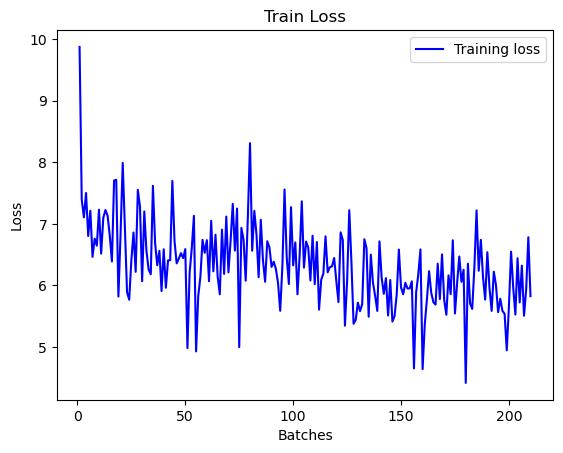

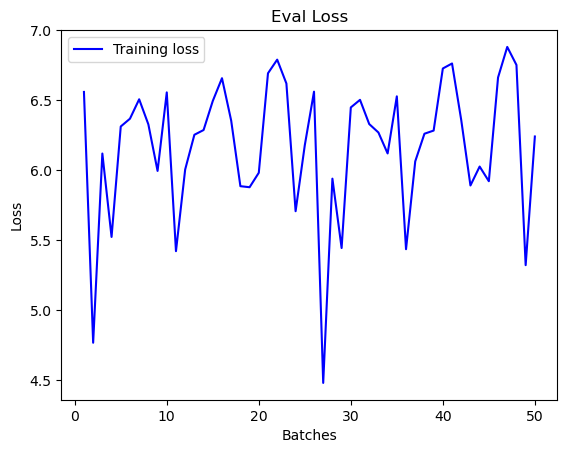

Best development accuracy improved from 0.1658390760421753 to 0.17313776910305023, saving model...

--- Training model Epoch: 3 ---
Training Iteration 0 of epoch 2 complete. Loss: 6.189971446990967; Acc:0.125; Time taken (s): 21.50369167327881
Training Iteration 500 of epoch 2 complete. Loss: 6.451956272125244; Acc:0.1171875; Time taken (s): 2.48600172996521
Training Iteration 1000 of epoch 2 complete. Loss: 5.939209461212158; Acc:0.1953125; Time taken (s): 2.4030017852783203
Training Iteration 1500 of epoch 2 complete. Loss: 5.395133018493652; Acc:0.203125; Time taken (s): 2.416001319885254
Training Iteration 2000 of epoch 2 complete. Loss: 6.65402889251709; Acc:0.1328125; Time taken (s): 2.4159069061279297
Training Iteration 2500 of epoch 2 complete. Loss: 5.0865254402160645; Acc:0.234375; Time taken (s): 2.410001516342163
Training Iteration 3000 of epoch 2 complete. Loss: 6.369984149932861; Acc:0.125; Time taken (s): 2.3930015563964844
Training Iteration 3500 of epoch 2 complete. Lo

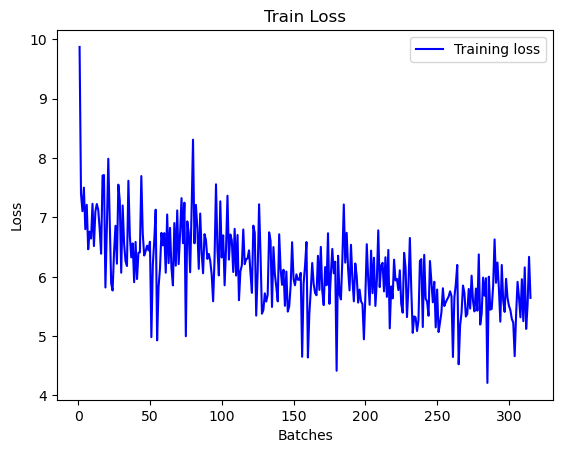

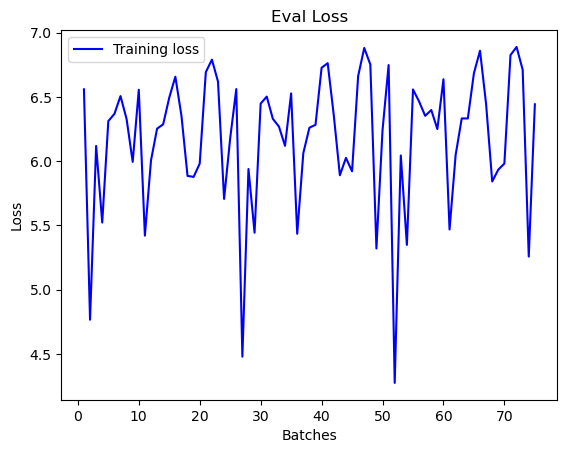

Best development accuracy improved from 0.17313776910305023 to 0.17522014677524567, saving model...

--- Training model Epoch: 4 ---
Training Iteration 0 of epoch 3 complete. Loss: 5.690464496612549; Acc:0.1875; Time taken (s): 21.85105276107788
Training Iteration 500 of epoch 3 complete. Loss: 6.104132175445557; Acc:0.140625; Time taken (s): 2.810001850128174
Training Iteration 1000 of epoch 3 complete. Loss: 5.702159881591797; Acc:0.15625; Time taken (s): 2.7640020847320557
Training Iteration 1500 of epoch 3 complete. Loss: 5.123235702514648; Acc:0.1875; Time taken (s): 2.750001907348633
Training Iteration 2000 of epoch 3 complete. Loss: 6.102307319641113; Acc:0.1640625; Time taken (s): 2.7620017528533936
Training Iteration 2500 of epoch 3 complete. Loss: 4.716555595397949; Acc:0.2421875; Time taken (s): 2.748002052307129
Training Iteration 3000 of epoch 3 complete. Loss: 6.120323657989502; Acc:0.1484375; Time taken (s): 2.7700016498565674
Training Iteration 3500 of epoch 3 complete.

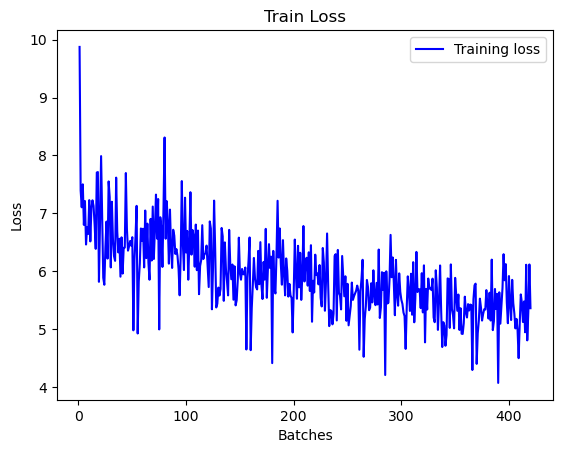

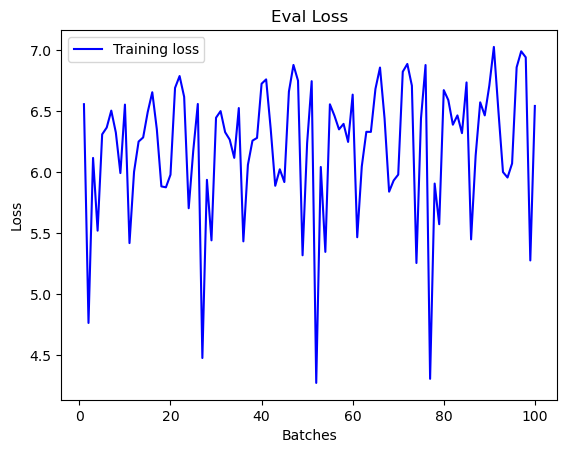


--- Training model Epoch: 5 ---
Training Iteration 0 of epoch 4 complete. Loss: 5.519118309020996; Acc:0.1640625; Time taken (s): 21.734940767288208
Training Iteration 500 of epoch 4 complete. Loss: 6.008815288543701; Acc:0.15625; Time taken (s): 2.8930017948150635
Training Iteration 1000 of epoch 4 complete. Loss: 5.529490947723389; Acc:0.1796875; Time taken (s): 2.7720019817352295
Training Iteration 1500 of epoch 4 complete. Loss: 4.9650468826293945; Acc:0.203125; Time taken (s): 2.758004903793335
Training Iteration 2000 of epoch 4 complete. Loss: 5.788995265960693; Acc:0.1953125; Time taken (s): 2.7580020427703857
Training Iteration 2500 of epoch 4 complete. Loss: 4.539414405822754; Acc:0.265625; Time taken (s): 2.7660017013549805
Training Iteration 3000 of epoch 4 complete. Loss: 5.864192008972168; Acc:0.1484375; Time taken (s): 2.7520017623901367
Training Iteration 3500 of epoch 4 complete. Loss: 5.38941764831543; Acc:0.1875; Time taken (s): 2.7590017318725586
Training Iteration 

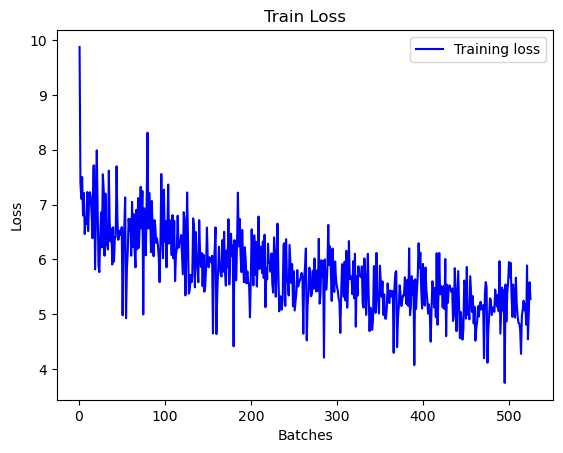

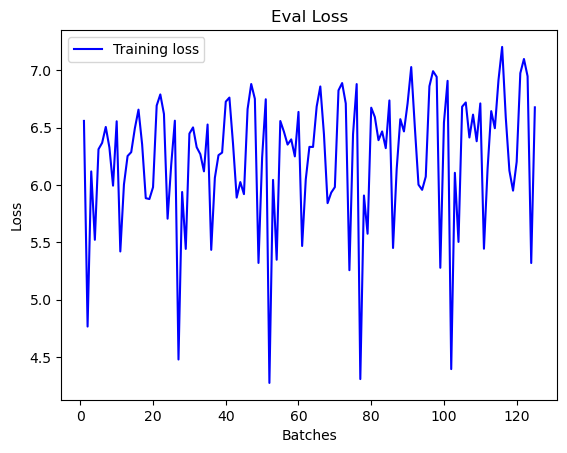


--- Training model Epoch: 6 ---
Training Iteration 0 of epoch 5 complete. Loss: 5.1554131507873535; Acc:0.1875; Time taken (s): 21.983907222747803
Training Iteration 500 of epoch 5 complete. Loss: 5.631128311157227; Acc:0.1640625; Time taken (s): 3.240001916885376
Training Iteration 1000 of epoch 5 complete. Loss: 5.36565637588501; Acc:0.15625; Time taken (s): 3.1600022315979004
Training Iteration 1500 of epoch 5 complete. Loss: 4.837687969207764; Acc:0.2109375; Time taken (s): 3.175002336502075
Training Iteration 2000 of epoch 5 complete. Loss: 5.620506763458252; Acc:0.2265625; Time taken (s): 3.172001838684082
Training Iteration 2500 of epoch 5 complete. Loss: 4.253345012664795; Acc:0.296875; Time taken (s): 3.1620023250579834
Training Iteration 3000 of epoch 5 complete. Loss: 5.489144802093506; Acc:0.15625; Time taken (s): 3.1480021476745605
Training Iteration 3500 of epoch 5 complete. Loss: 5.164896488189697; Acc:0.234375; Time taken (s): 3.1470062732696533
Training Iteration 4000

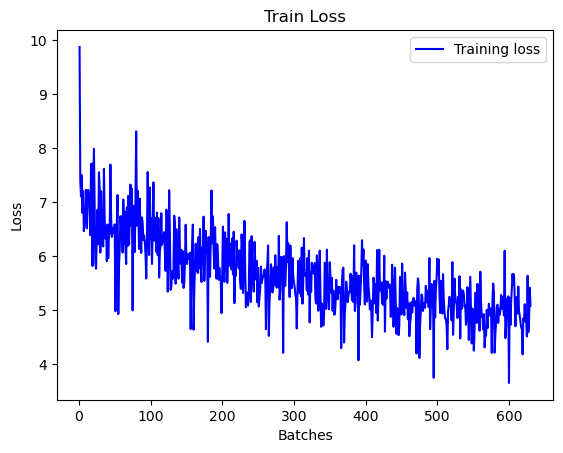

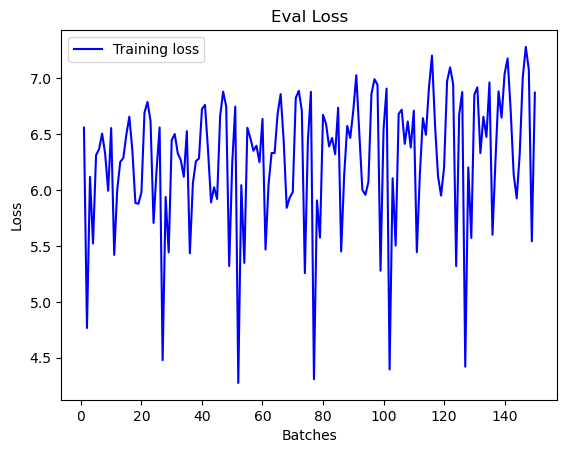


--- Training model Epoch: 7 ---
Training Iteration 0 of epoch 6 complete. Loss: 5.146103858947754; Acc:0.203125; Time taken (s): 21.93762731552124
Training Iteration 500 of epoch 6 complete. Loss: 5.467742443084717; Acc:0.21875; Time taken (s): 2.8960020542144775
Training Iteration 1000 of epoch 6 complete. Loss: 5.128065586090088; Acc:0.1953125; Time taken (s): 2.7100024223327637
Training Iteration 1500 of epoch 6 complete. Loss: 4.6081671714782715; Acc:0.203125; Time taken (s): 2.726001501083374
Training Iteration 2000 of epoch 6 complete. Loss: 5.2723517417907715; Acc:0.1953125; Time taken (s): 2.734001636505127
Training Iteration 2500 of epoch 6 complete. Loss: 4.106316089630127; Acc:0.3125; Time taken (s): 2.7720017433166504
Training Iteration 3000 of epoch 6 complete. Loss: 5.409046649932861; Acc:0.1796875; Time taken (s): 2.7190022468566895
Training Iteration 3500 of epoch 6 complete. Loss: 5.1178154945373535; Acc:0.1953125; Time taken (s): 2.752002000808716
Training Iteration 

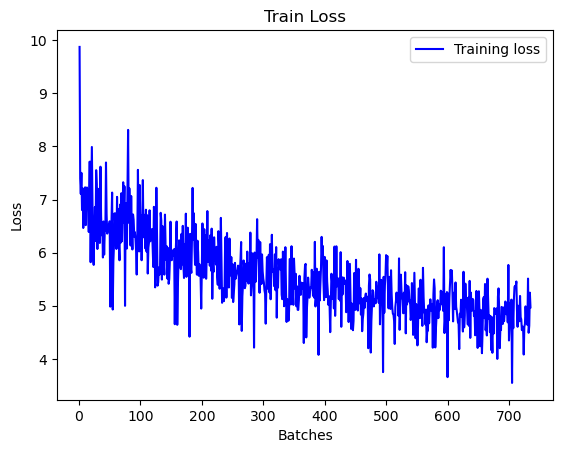

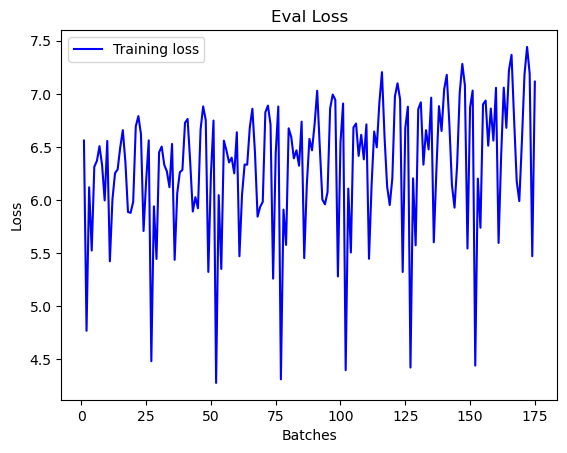


--- Training model Epoch: 8 ---
Training Iteration 0 of epoch 7 complete. Loss: 4.844752788543701; Acc:0.1953125; Time taken (s): 21.487979412078857
Training Iteration 500 of epoch 7 complete. Loss: 5.317453384399414; Acc:0.234375; Time taken (s): 2.856001138687134
Training Iteration 1000 of epoch 7 complete. Loss: 4.993710041046143; Acc:0.1953125; Time taken (s): 2.7940022945404053
Training Iteration 1500 of epoch 7 complete. Loss: 4.368869781494141; Acc:0.2421875; Time taken (s): 2.7890024185180664
Training Iteration 2000 of epoch 7 complete. Loss: 5.073974609375; Acc:0.203125; Time taken (s): 2.7950010299682617
Training Iteration 2500 of epoch 7 complete. Loss: 4.071560859680176; Acc:0.359375; Time taken (s): 2.7590017318725586
Training Iteration 3000 of epoch 7 complete. Loss: 5.359243392944336; Acc:0.1640625; Time taken (s): 2.803001642227173
Training Iteration 3500 of epoch 7 complete. Loss: 4.811558723449707; Acc:0.21875; Time taken (s): 2.7810020446777344
Training Iteration 40

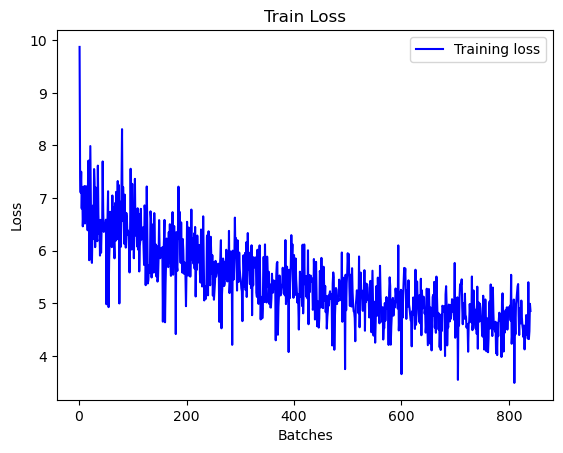

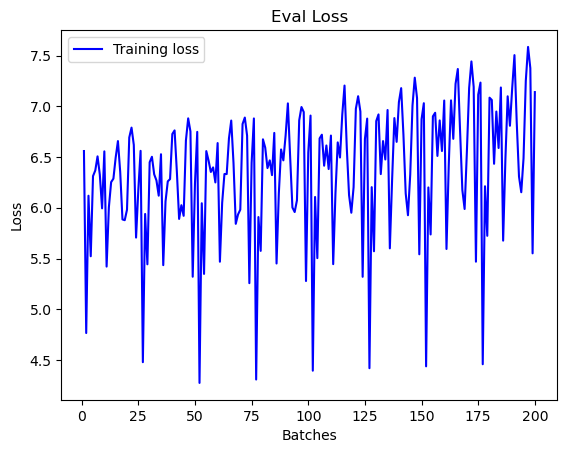


--- Training model Epoch: 9 ---
Training Iteration 0 of epoch 8 complete. Loss: 4.76584005355835; Acc:0.2109375; Time taken (s): 21.473058223724365
Training Iteration 500 of epoch 8 complete. Loss: 5.179461479187012; Acc:0.2109375; Time taken (s): 2.868001937866211
Training Iteration 1000 of epoch 8 complete. Loss: 4.899557590484619; Acc:0.1796875; Time taken (s): 2.7640018463134766
Training Iteration 1500 of epoch 8 complete. Loss: 4.3597564697265625; Acc:0.265625; Time taken (s): 2.7580018043518066
Training Iteration 2000 of epoch 8 complete. Loss: 4.756218433380127; Acc:0.2578125; Time taken (s): 2.819002151489258
Training Iteration 2500 of epoch 8 complete. Loss: 3.9206652641296387; Acc:0.3203125; Time taken (s): 2.7880020141601562
Training Iteration 3000 of epoch 8 complete. Loss: 5.279199600219727; Acc:0.171875; Time taken (s): 2.802001714706421
Training Iteration 3500 of epoch 8 complete. Loss: 4.7018232345581055; Acc:0.2578125; Time taken (s): 2.803001880645752
Training Iterat

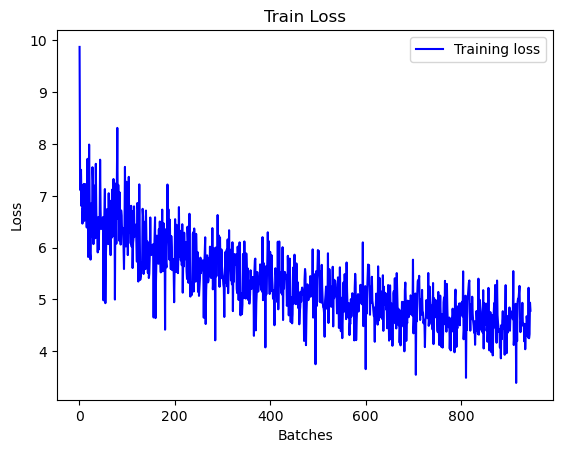

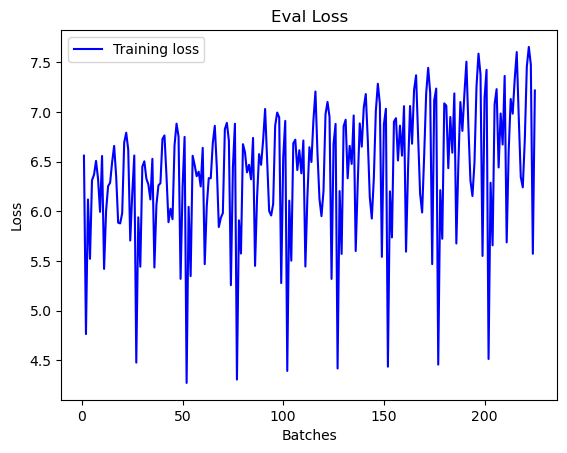


--- Training model Epoch: 10 ---
Training Iteration 0 of epoch 9 complete. Loss: 4.59209680557251; Acc:0.2265625; Time taken (s): 22.456867933273315
Training Iteration 500 of epoch 9 complete. Loss: 5.209530830383301; Acc:0.2109375; Time taken (s): 3.2575223445892334
Training Iteration 1000 of epoch 9 complete. Loss: 4.717970371246338; Acc:0.2421875; Time taken (s): 3.1650028228759766
Training Iteration 1500 of epoch 9 complete. Loss: 4.286947250366211; Acc:0.2734375; Time taken (s): 3.2060019969940186
Training Iteration 2000 of epoch 9 complete. Loss: 4.683897495269775; Acc:0.25; Time taken (s): 3.1337175369262695
Training Iteration 2500 of epoch 9 complete. Loss: 3.8334078788757324; Acc:0.3671875; Time taken (s): 3.173673391342163
Training Iteration 3000 of epoch 9 complete. Loss: 5.1967453956604; Acc:0.21875; Time taken (s): 3.181002140045166
Training Iteration 3500 of epoch 9 complete. Loss: 4.648312568664551; Acc:0.2421875; Time taken (s): 3.186002016067505
Training Iteration 400

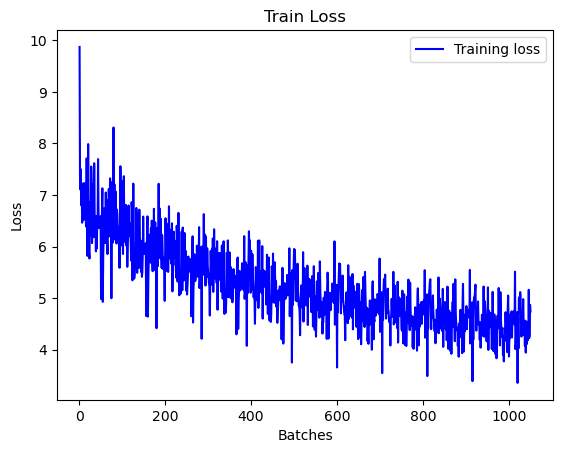

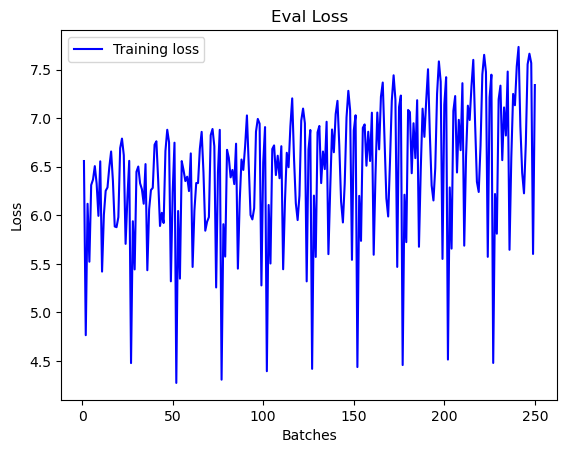


--- Training model Epoch: 11 ---
Training Iteration 0 of epoch 10 complete. Loss: 4.549285411834717; Acc:0.2578125; Time taken (s): 21.87279462814331
Training Iteration 500 of epoch 10 complete. Loss: 5.100692272186279; Acc:0.2578125; Time taken (s): 3.2382352352142334
Training Iteration 1000 of epoch 10 complete. Loss: 4.529780864715576; Acc:0.21875; Time taken (s): 3.1380019187927246
Training Iteration 1500 of epoch 10 complete. Loss: 4.149209976196289; Acc:0.3203125; Time taken (s): 3.126340627670288
Training Iteration 2000 of epoch 10 complete. Loss: 4.461194038391113; Acc:0.28125; Time taken (s): 3.1591503620147705
Training Iteration 2500 of epoch 10 complete. Loss: 3.8152146339416504; Acc:0.328125; Time taken (s): 3.1610023975372314
Training Iteration 3000 of epoch 10 complete. Loss: 5.081496238708496; Acc:0.171875; Time taken (s): 3.1646077632904053
Training Iteration 3500 of epoch 10 complete. Loss: 4.6987714767456055; Acc:0.2421875; Time taken (s): 3.1600053310394287
Training

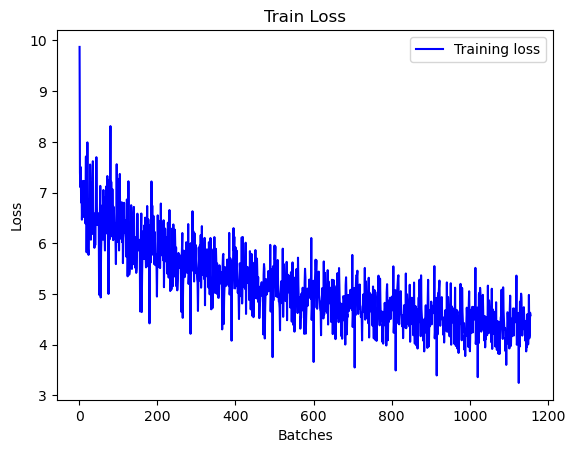

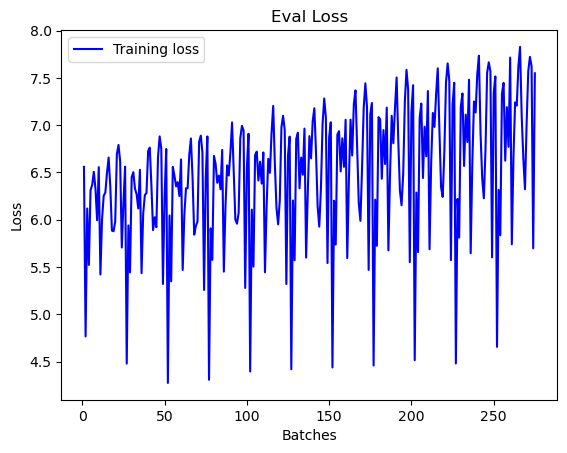


--- Training model Epoch: 12 ---
Training Iteration 0 of epoch 11 complete. Loss: 4.460241317749023; Acc:0.2421875; Time taken (s): 21.438204050064087
Training Iteration 500 of epoch 11 complete. Loss: 5.072484016418457; Acc:0.2421875; Time taken (s): 2.924002170562744
Training Iteration 1000 of epoch 11 complete. Loss: 4.433943271636963; Acc:0.2109375; Time taken (s): 2.760749578475952
Training Iteration 1500 of epoch 11 complete. Loss: 4.119265556335449; Acc:0.2890625; Time taken (s): 2.755002021789551
Training Iteration 2000 of epoch 11 complete. Loss: 4.2857561111450195; Acc:0.2890625; Time taken (s): 2.7570016384124756
Training Iteration 2500 of epoch 11 complete. Loss: 3.7126731872558594; Acc:0.34375; Time taken (s): 2.7660019397735596
Training Iteration 3000 of epoch 11 complete. Loss: 4.960453987121582; Acc:0.1875; Time taken (s): 2.754824638366699
Training Iteration 3500 of epoch 11 complete. Loss: 4.6153082847595215; Acc:0.2734375; Time taken (s): 2.754002094268799
Training 

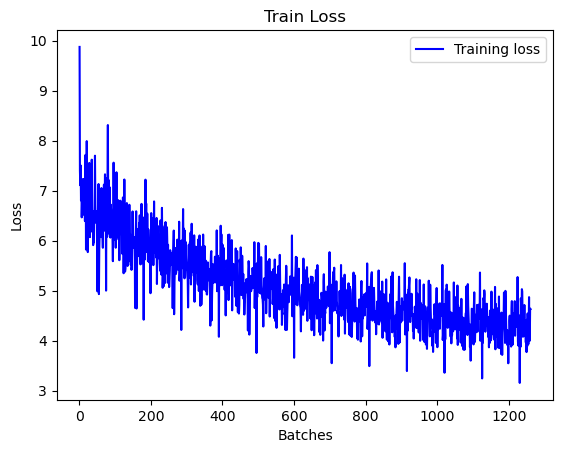

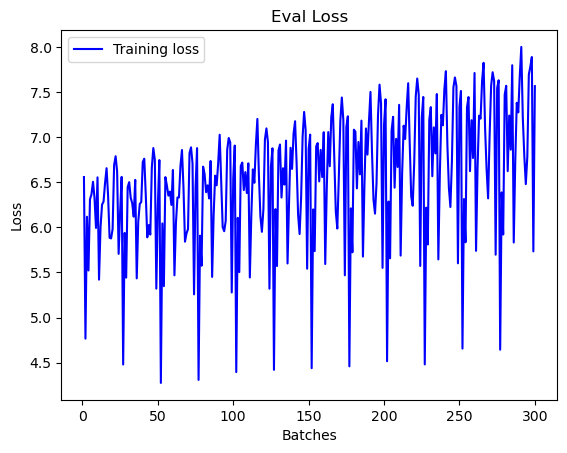


--- Training model Epoch: 13 ---
Training Iteration 0 of epoch 12 complete. Loss: 4.3365278244018555; Acc:0.265625; Time taken (s): 21.01678466796875
Training Iteration 500 of epoch 12 complete. Loss: 4.955123424530029; Acc:0.21875; Time taken (s): 2.859002113342285
Training Iteration 1000 of epoch 12 complete. Loss: 4.279561519622803; Acc:0.265625; Time taken (s): 2.7620017528533936
Training Iteration 1500 of epoch 12 complete. Loss: 4.019313812255859; Acc:0.3359375; Time taken (s): 2.743001699447632
Training Iteration 2000 of epoch 12 complete. Loss: 4.30088996887207; Acc:0.28125; Time taken (s): 2.7790770530700684
Training Iteration 2500 of epoch 12 complete. Loss: 3.617940664291382; Acc:0.390625; Time taken (s): 2.784860849380493
Training Iteration 3000 of epoch 12 complete. Loss: 4.8613457679748535; Acc:0.21875; Time taken (s): 2.7720017433166504
Training Iteration 3500 of epoch 12 complete. Loss: 4.58690071105957; Acc:0.28125; Time taken (s): 2.7730019092559814
Training Iteratio

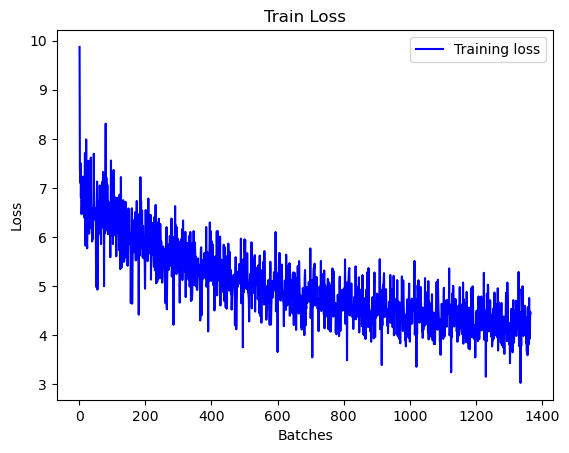

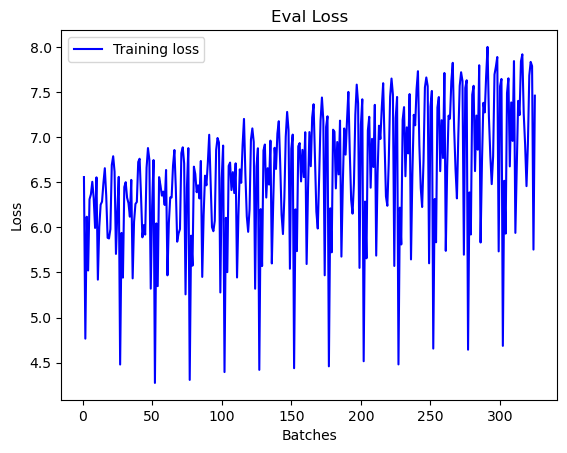


--- Training model Epoch: 14 ---
Training Iteration 0 of epoch 13 complete. Loss: 4.341101169586182; Acc:0.2578125; Time taken (s): 21.471948862075806
Training Iteration 500 of epoch 13 complete. Loss: 5.015414714813232; Acc:0.2734375; Time taken (s): 2.9160022735595703
Training Iteration 1000 of epoch 13 complete. Loss: 4.252929210662842; Acc:0.2578125; Time taken (s): 2.7777297496795654
Training Iteration 1500 of epoch 13 complete. Loss: 4.108275890350342; Acc:0.28125; Time taken (s): 2.772510290145874
Training Iteration 2000 of epoch 13 complete. Loss: 4.2264909744262695; Acc:0.28125; Time taken (s): 2.7844693660736084
Training Iteration 2500 of epoch 13 complete. Loss: 3.714888572692871; Acc:0.3515625; Time taken (s): 2.7630019187927246
Training Iteration 3000 of epoch 13 complete. Loss: 4.7434186935424805; Acc:0.25; Time taken (s): 2.9460020065307617
Training Iteration 3500 of epoch 13 complete. Loss: 4.443211555480957; Acc:0.28125; Time taken (s): 3.110002040863037
Training Iter

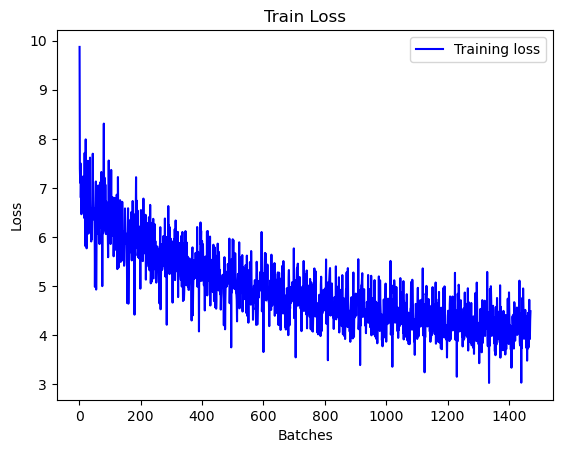

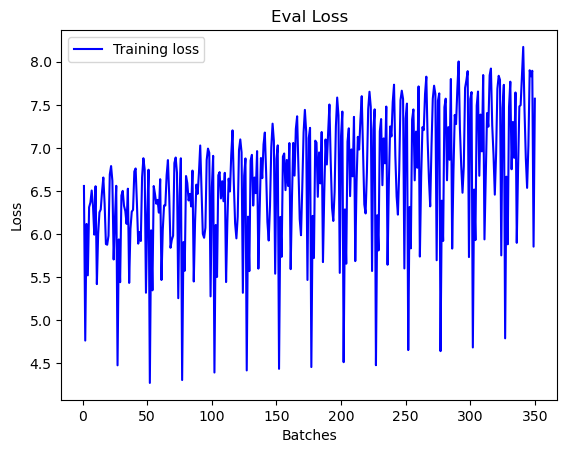


--- Training model Epoch: 15 ---
Training Iteration 0 of epoch 14 complete. Loss: 4.185314178466797; Acc:0.2734375; Time taken (s): 21.138686180114746
Training Iteration 500 of epoch 14 complete. Loss: 4.921701431274414; Acc:0.25; Time taken (s): 2.8410019874572754
Training Iteration 1000 of epoch 14 complete. Loss: 4.146242141723633; Acc:0.28125; Time taken (s): 2.770040988922119
Training Iteration 1500 of epoch 14 complete. Loss: 3.984405517578125; Acc:0.3203125; Time taken (s): 2.7780017852783203
Training Iteration 2000 of epoch 14 complete. Loss: 4.134449005126953; Acc:0.3125; Time taken (s): 2.7620017528533936
Training Iteration 2500 of epoch 14 complete. Loss: 3.6175830364227295; Acc:0.359375; Time taken (s): 2.756005048751831
Training Iteration 3000 of epoch 14 complete. Loss: 4.769115447998047; Acc:0.203125; Time taken (s): 2.759812116622925
Training Iteration 3500 of epoch 14 complete. Loss: 4.483603000640869; Acc:0.25; Time taken (s): 2.7705678939819336
Training Iteration 40

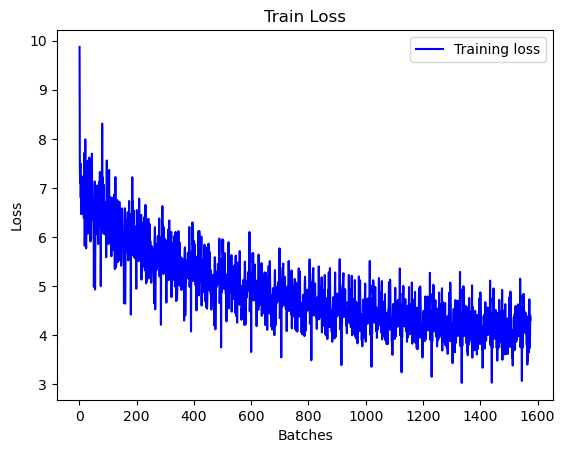

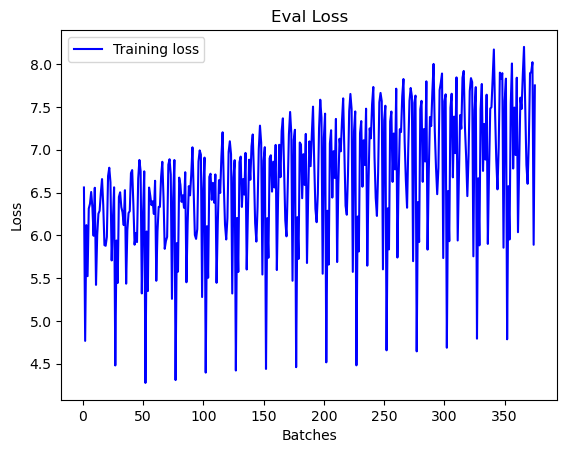


--- Training model Epoch: 16 ---
Training Iteration 0 of epoch 15 complete. Loss: 4.308355331420898; Acc:0.2421875; Time taken (s): 21.327513933181763
Training Iteration 500 of epoch 15 complete. Loss: 4.816052436828613; Acc:0.2578125; Time taken (s): 2.91500186920166
Training Iteration 1000 of epoch 15 complete. Loss: 4.075256824493408; Acc:0.2890625; Time taken (s): 2.765002489089966
Training Iteration 1500 of epoch 15 complete. Loss: 4.031632900238037; Acc:0.3203125; Time taken (s): 2.755002021789551
Training Iteration 2000 of epoch 15 complete. Loss: 4.0489325523376465; Acc:0.34375; Time taken (s): 2.7536940574645996
Training Iteration 2500 of epoch 15 complete. Loss: 3.578770637512207; Acc:0.3984375; Time taken (s): 2.7610018253326416
Training Iteration 3000 of epoch 15 complete. Loss: 4.6228928565979; Acc:0.2265625; Time taken (s): 2.753814935684204
Training Iteration 3500 of epoch 15 complete. Loss: 4.447484493255615; Acc:0.25; Time taken (s): 2.7580020427703857
Training Iterat

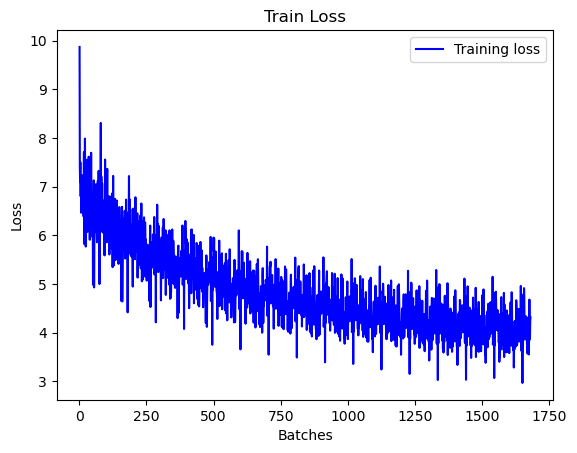

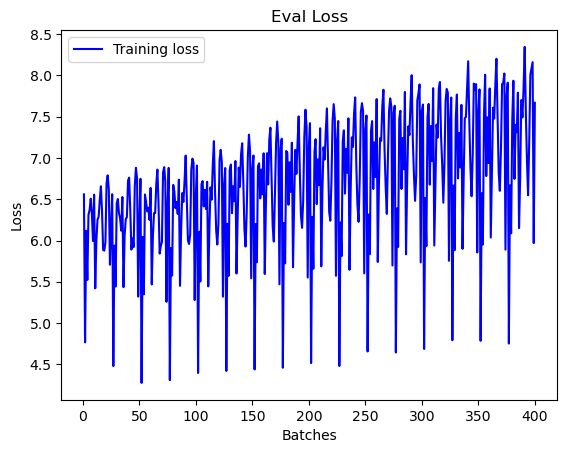


--- Training model Epoch: 17 ---
Training Iteration 0 of epoch 16 complete. Loss: 4.273386001586914; Acc:0.28125; Time taken (s): 21.47375464439392
Training Iteration 500 of epoch 16 complete. Loss: 4.822971343994141; Acc:0.2734375; Time taken (s): 2.8290019035339355
Training Iteration 1000 of epoch 16 complete. Loss: 4.120941638946533; Acc:0.2421875; Time taken (s): 2.7720017433166504
Training Iteration 1500 of epoch 16 complete. Loss: 3.922820568084717; Acc:0.328125; Time taken (s): 2.793792963027954
Training Iteration 2000 of epoch 16 complete. Loss: 3.9384605884552; Acc:0.3203125; Time taken (s): 2.7770018577575684
Training Iteration 2500 of epoch 16 complete. Loss: 3.4026622772216797; Acc:0.375; Time taken (s): 2.7790019512176514
Training Iteration 3000 of epoch 16 complete. Loss: 4.523242473602295; Acc:0.2578125; Time taken (s): 2.770761013031006
Training Iteration 3500 of epoch 16 complete. Loss: 4.335210800170898; Acc:0.2734375; Time taken (s): 2.7820019721984863
Training Iter

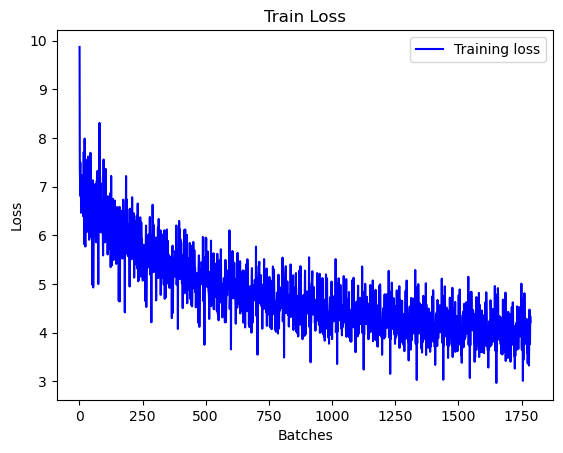

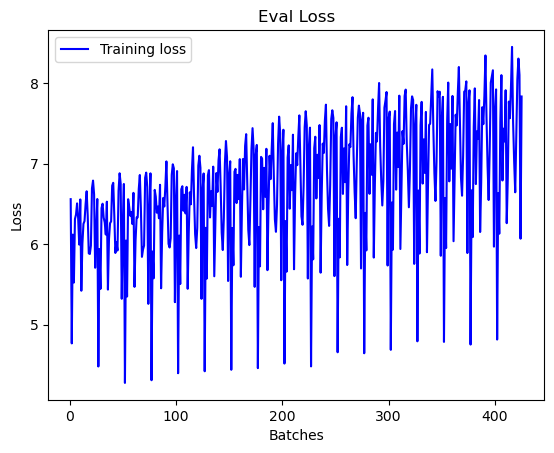


--- Training model Epoch: 18 ---
Training Iteration 0 of epoch 17 complete. Loss: 4.22437047958374; Acc:0.296875; Time taken (s): 21.27983832359314
Training Iteration 500 of epoch 17 complete. Loss: 4.748579025268555; Acc:0.2421875; Time taken (s): 2.8329460620880127
Training Iteration 1000 of epoch 17 complete. Loss: 4.034687519073486; Acc:0.28125; Time taken (s): 2.7840018272399902
Training Iteration 1500 of epoch 17 complete. Loss: 3.8431873321533203; Acc:0.3046875; Time taken (s): 2.7510018348693848
Training Iteration 2000 of epoch 17 complete. Loss: 3.8162918090820312; Acc:0.375; Time taken (s): 2.7620019912719727
Training Iteration 2500 of epoch 17 complete. Loss: 3.5222718715667725; Acc:0.375; Time taken (s): 2.7780017852783203
Training Iteration 3000 of epoch 17 complete. Loss: 4.518559455871582; Acc:0.2578125; Time taken (s): 2.7806901931762695
Training Iteration 3500 of epoch 17 complete. Loss: 4.364871978759766; Acc:0.3046875; Time taken (s): 2.794856071472168
Training Iter

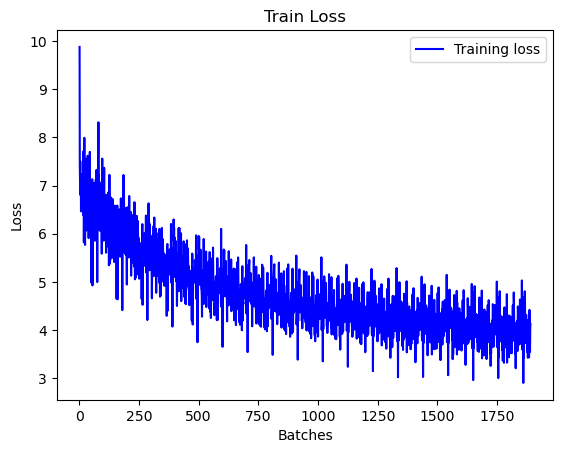

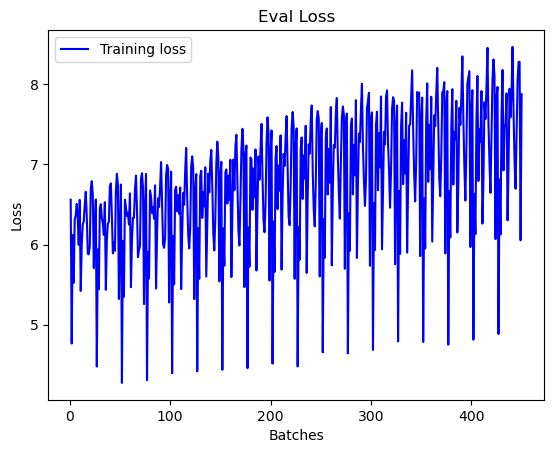


--- Training model Epoch: 19 ---
Training Iteration 0 of epoch 18 complete. Loss: 4.225348949432373; Acc:0.2890625; Time taken (s): 21.049028635025024
Training Iteration 500 of epoch 18 complete. Loss: 4.709191799163818; Acc:0.265625; Time taken (s): 2.8970019817352295
Training Iteration 1000 of epoch 18 complete. Loss: 4.118938446044922; Acc:0.296875; Time taken (s): 2.7710018157958984
Training Iteration 1500 of epoch 18 complete. Loss: 3.813110113143921; Acc:0.3359375; Time taken (s): 2.765183687210083
Training Iteration 2000 of epoch 18 complete. Loss: 3.8517425060272217; Acc:0.359375; Time taken (s): 2.775300979614258
Training Iteration 2500 of epoch 18 complete. Loss: 3.3996763229370117; Acc:0.3984375; Time taken (s): 2.787001848220825
Training Iteration 3000 of epoch 18 complete. Loss: 4.634352207183838; Acc:0.2734375; Time taken (s): 2.7702274322509766
Training Iteration 3500 of epoch 18 complete. Loss: 4.3156304359436035; Acc:0.3125; Time taken (s): 2.79000186920166
Training I

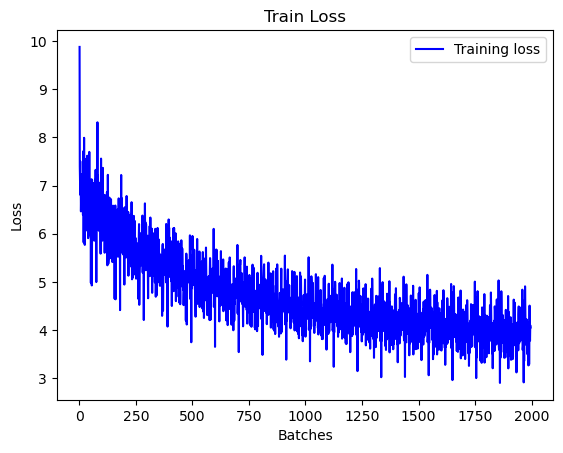

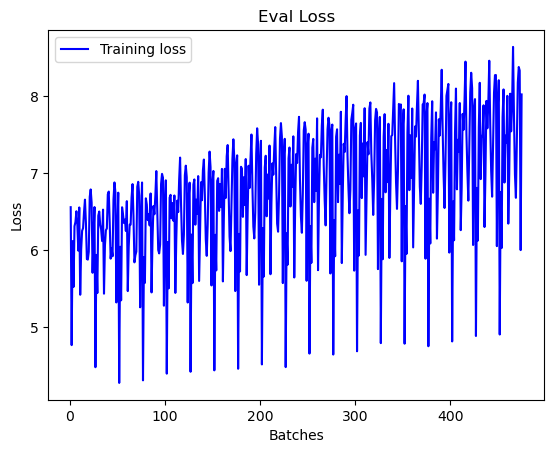


--- Training model Epoch: 20 ---
Training Iteration 0 of epoch 19 complete. Loss: 4.230437755584717; Acc:0.2734375; Time taken (s): 21.098045349121094
Training Iteration 500 of epoch 19 complete. Loss: 4.699344635009766; Acc:0.2421875; Time taken (s): 3.122027635574341
Training Iteration 1000 of epoch 19 complete. Loss: 4.000049114227295; Acc:0.3203125; Time taken (s): 2.789001703262329
Training Iteration 1500 of epoch 19 complete. Loss: 3.808177947998047; Acc:0.359375; Time taken (s): 2.917520523071289
Training Iteration 2000 of epoch 19 complete. Loss: 3.7878901958465576; Acc:0.3671875; Time taken (s): 3.110002279281616
Training Iteration 2500 of epoch 19 complete. Loss: 3.473006248474121; Acc:0.375; Time taken (s): 3.114140510559082
Training Iteration 3000 of epoch 19 complete. Loss: 4.50799036026001; Acc:0.234375; Time taken (s): 3.102144479751587
Training Iteration 3500 of epoch 19 complete. Loss: 4.203780651092529; Acc:0.28125; Time taken (s): 3.1140027046203613
Training Iterati

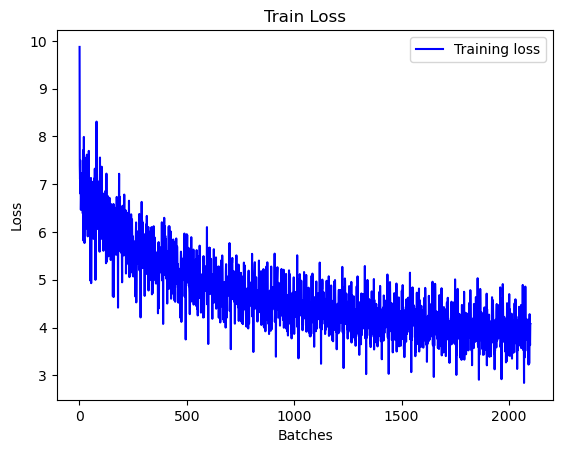

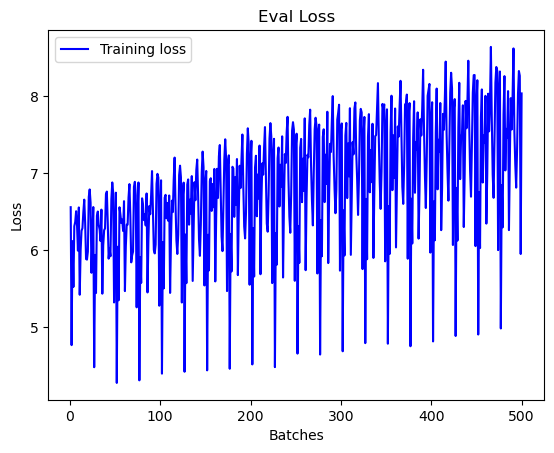

In [32]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
model = fiveGramNNmodel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, H)

# load it to gpu
model.cuda(gpu)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)


# ------------------------- TRAIN & SAVE MODEL ------------------------
best_acc = 0
best_model_path = None
train_losses = []
eval_losses = []
for epoch in range(20):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(train_loader):       
        context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
        target_tensor = data_tensor[:,4].type(torch.LongTensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probs(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            train_losses.append(loss.item())
        if it % 500 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}".format(it, epoch, loss.item(), acc, (time.time()-st)))
            st = time.time()

    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss, e_losses = evaluate(model, loss_function, test_loader, gpu)
    eval_losses = eval_losses + e_losses
    print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(epoch, dev_acc, dev_loss))
    
    plot_loss(train_losses, "Train Loss")
    plot_loss(eval_losses, "Eval Loss")
    
    if dev_acc > best_acc:
        print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        # set best model path
        best_model_path = 'models/best_fivegram_model_{}.dat'.format(epoch)
        # saving best model
        torch.save(model.state_dict(), best_model_path)